In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from winkie import ml
from winkie import dlc_importer
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
model = keras.models.load_model("model_7s-1000e-256b-0015L")
model

In [4]:
imp = dlc_importer.DLCImporter()
df = imp.import_hdf('233_monhab_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5')
df

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
0          723.830383  267.671021   1.000000  860.289124  326.120514   
1          723.319702  267.876190   1.000000  859.872375  325.745544   
2          722.189514  267.835907   1.000000  860.235046  325.532013   
3          720.339294  267.004486   1.000000  859.815247  325.567383   
4          718.141113  268.313232   1.000000  860.307251  325.352753   
...               ...         ...        ...         ...         ...   
71921      649.002747  221.839203   0.244375  860.507629  324.114960   
71922      648.700378  222.646729   0.536838  860.277283  323.774231   
71923      649.552490  222.885101   0.443782  860.395447  323.587585   
71924      649.723450  222.148682   0.159346  860.205322  324.356567   
71925      407.650238  190.689575   0.142819  859.770020  324.202087   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
0           0.999380  712.175720  324.045685   0.999999  761.088867  ...   
1           0.997965  712.066162  325.288208   0.999999  760.937500  ...   
2           0.997720  711.768799  326.076996   0.999999  760.209839  ...   
3           0.998791  710.794678  327.501434   0.999998  759.058960  ...   
4           0.998659  709.961243  327.660492   0.999999  757.261719  ...   
...              ...         ...         ...        ...         ...  ...   
71921       0.981410  422.653656  201.851364   0.999973  436.030914  ...   
71922       0.987438  422.820587  202.849701   0.999972  435.021667  ...   
71923       0.989376  422.949219  203.948380   0.999962  434.903473  ...   
71924       0.977795  422.112091  205.227325   0.999942  435.331543  ...   
71925       0.979869  421.485962  206.176544   0.999868  433.530823  ...   

bodyparts right_middle_wing right_down_wing                         \
coords           likelihood               x           y likelihood   
0                  0.999867      845.145996  509.003174   0.999693   
1                  0.999910      846.128418  508.736755   0.999535   
2                  0.999887      846.454712  509.129913   0.999406   
3                  0.999907      845.741882  508.743866   0.998147   
4                  0.999882      845.509766  510.201965   0.999089   
...                     ...             ...         ...        ...   
71921              0.066531      615.500610  201.737808   0.819033   
71922              0.095435      616.532471  202.007385   0.854375   
71923              0.073202      617.392212  202.671387   0.857885   
71924              0.089979      617.242310  201.189682   0.805269   
71925              0.051352      618.149841  198.847000   0.921775   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
0          782.097778  406.166809   0.999977  855.370239  574.876587   
1          782.325439  406.430115   0.999986  854.977844  574.437744   
2          781.783386  405.989777   0.999984  855.112488  574.747070   
3          781.808960  405.897339   0.999977  855.986877  573.519836   
4          781.652893  405.649475   0.999981  854.078552  574.682129   
...               ...         ...        ...         ...         ...   
71921      523.067200  191.594757   0.995899  646.028259  230.423325   
71922      522.576538  193.316086   0.998430  646.586182  229.648087   
71923      520.964539  192.325394   0.996701  647.094788  229.874207   
71924      521.547791  191.358871   0.997931  647.567749  229.604721   
71925      522.181763  191.650894   0.995298  647.461853  229.695084   

bodyparts             
coords    likelihood  
0           0.999997  
1           0.999996  
2           0.999996  
3           0.999997  
4           0.999998  
...              ...  
71921       0.995597  
71922       0.99545

In [5]:
def build_timeseries(df, features, timeslice_length):
    "Split the data in `df` into timeseries segments of length `timeslice_length` containing given `features`."
    
    segments = []
    for i in range(0, len(df) - timeslice_length + 1, timeslice_length):
        s = []
        i_end = i + timeslice_length
        for f in features:
            s.append(df[f[0], f[1]].values[i:i_end])
            
        segments.append(s)

    return np.asarray(segments).reshape(-1, timeslice_length, len(features))

In [6]:
features = [('head', 'x'), ('head', 'y'), ('tail', 'x'), ('left_neck', 'y'), ('right_neck', 'y')]
timeslice = 7
segments = build_timeseries(df, features, timeslice)

In [7]:
predictions = model.predict(segments)

In [33]:
classes = pd.Series(np.argmax(predictions, axis = 1)).repeat(timeslice).reset_index(drop=True)

confidence = pd.Series(np.max(predictions, axis = 1)).repeat(timeslice).reset_index(drop=True)

df['class'] = classes
df['confidence'] = confidence

In [60]:
df.loc[(df['confidence'] < 0.99), 'class'] = -1

<AxesSubplot:>

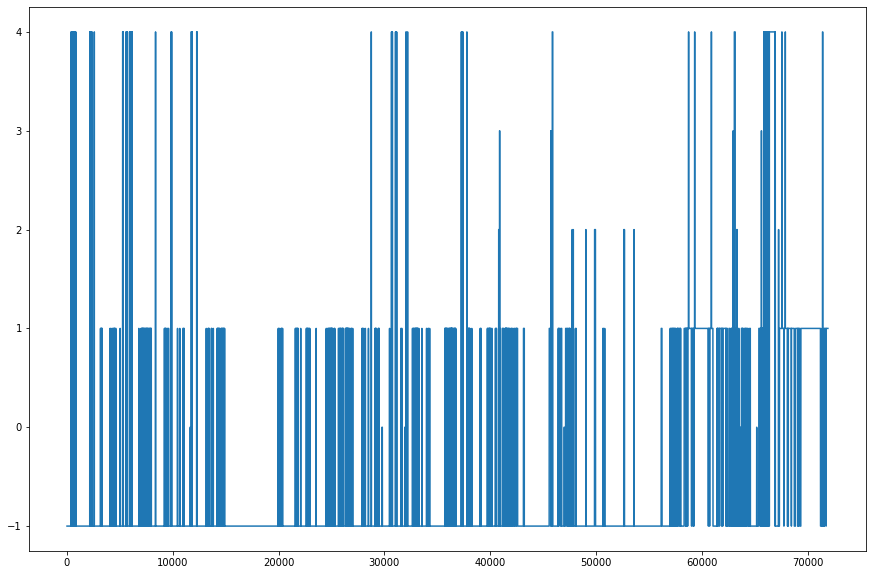

In [61]:
df['class'].plot()

In [84]:
hs = df[df['class'] == 1.0].index.values

hs / 119.88

array([ 26.334668  ,  26.34300968,  26.35135135, ..., 599.94994995,
       599.95829162, 599.9666333 ])

In [83]:
df.iloc[44350:44500, ]

bodyparts        head                              beak              \
coords              x          y likelihood           x           y   
44350      766.424866  56.589512   0.999994  788.263062   38.712700   
44351      765.822021  57.898365   0.999993  787.632080   38.607353   
44352      765.800476  57.477455   0.999993  787.768250   38.377705   
44353      767.094116  56.416817   0.999987  787.971436   38.606293   
44354      767.238892  56.919041   0.999988  787.867554   38.493835   
...               ...        ...        ...         ...         ...   
44495      798.042236  62.399208   0.999976  859.468445  324.426361   
44496      798.940979  62.390854   0.999978  860.213318  324.343262   
44497      798.533081  62.531845   0.999957  817.620789   64.531853   
44498      799.340576  61.981422   0.999965  860.131226  323.519226   
44499      798.811829  61.839878   0.999984  818.809631   64.272293   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
44350       0.999998  715.559753  116.665047   0.999996  793.267761  ...   
44351       0.999998  715.175659  117.865875   0.999996  793.029907  ...   
44352       0.999999  715.859985  117.607918   0.999996  793.071472  ...   
44353       0.999998  715.809387  117.189644   0.999998  793.114868  ...   
44354       0.999998  715.818359  117.047569   0.999996  793.370728  ...   
...              ...         ...         ...        ...         ...  ...   
44495       0.951819  725.004089  109.918541   0.999998  797.092957  ...   
44496       0.976362  723.570801  111.476036   0.999998  797.359192  ...   
44497       0.893331  723.918823  111.502357   0.999997  797.806213  ...   
44498       0.927300  724.835815  110.643852   0.999995  798.211182  ...   
44499       0.975809  724.067627  111.602066   0.999997  798.877625  ...   

bodyparts right_down_wing                   body                         \
coords                  y likelihood           x           y likelihood   
44350          333.949799   0.999985  743.284607  214.275375   0.999990   
44351          334.012268   0.999990  742.428162  215.072525   0.999991   
44352          332.866699   0.999993  741.861206  215.260056   0.999991   
44353          334.171387   0.999971  741.686523  215.729263   0.999987   
44354          333.803894   0.999993  742.862488  215.176956   0.999986   
...                   ...        ...         ...         ...        ...   
44495          336.037231   0.999977  735.614319  216.963852   0.999989   
44496          337.228546   0.999991  735.061157  216.194885   0.999994   
44497          336.299927   0.999990  736.290649  216.284470   0.999985   
44498          336.706543   0.999992  736.293762  216.346283   0.999989   
44499          336.101959   0.999992  736.251465  217.287064   0.999991   

bodyparts        tail                        class confidence  
coords              x           y likelihood                   
44350      728.851135  370.667664   0.999994  -1.0   0.975417  
44351      727.879272  371.024109   0.999972  -1.0   0.975417  
44352      728.023071  370.740692   0.999978  -1.0   0.984852  
44353      727.412903  370.570648   0.999987  -1.0   0.984852  
44354      728.365112  370.318237   0.999993  -1.0   0.984852  
...               ...         ...        ...   ...        ...  
44495      715.763245  373.992798   0.999938  -1.0   0.630582  
44496      713.959045  373.844055   0.999875  -1.0   0.630582  
44497      714.030090  373.647583   0.999944  -1.0   0.630582  
44498      713.909729  373.123749   0.999957  -1.0   0.630582  
44499      714.038086  372.470825   0.999949  -1.0   0.653243  

[150 rows x 38 columns]

In [27]:
5.8763248e-01

0.58763248

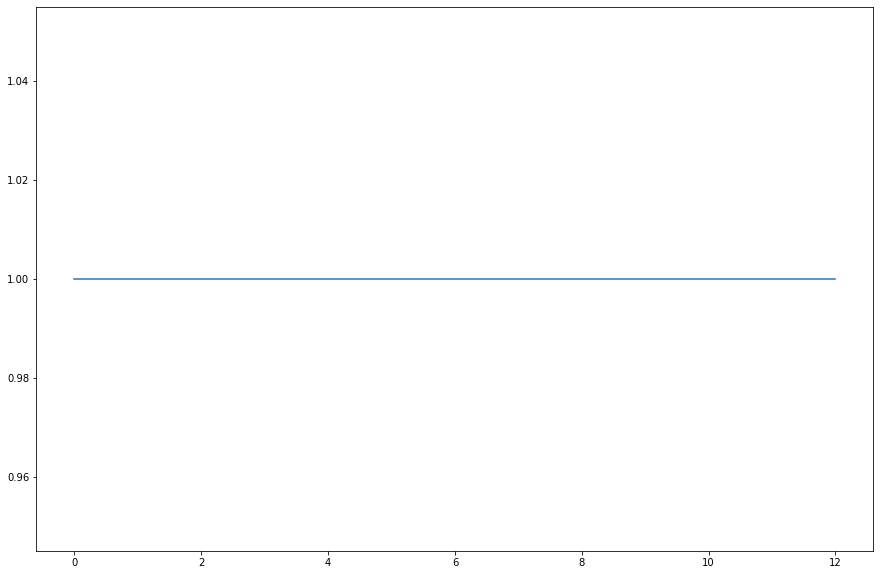

In [31]:
predictions_slice = model.predict(build_timeseries(df.iloc[slice(69666,70453)], features, timeslice))
predictions_slice
classes = np.argmax(predictions_slice, axis = 1)
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(classes)

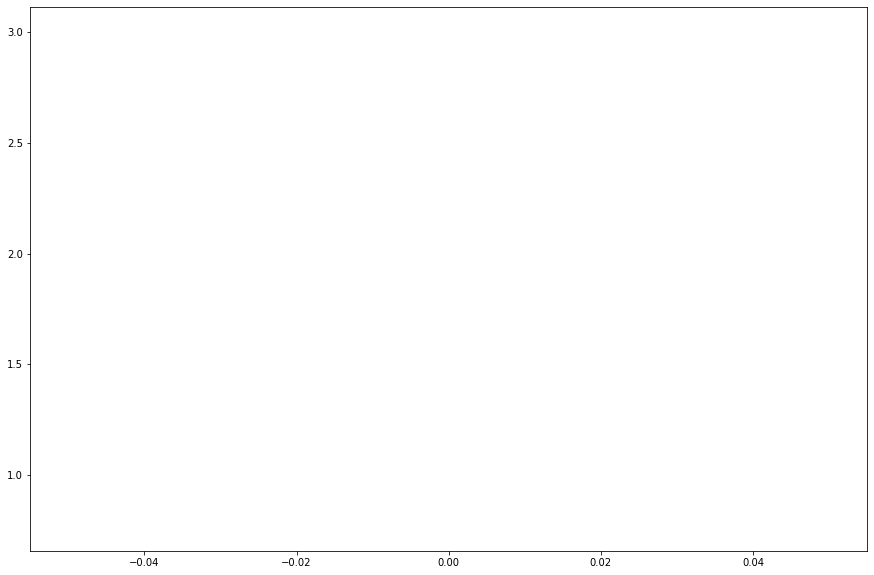

In [38]:

predictions_slice = model.predict(build_timeseries(df.iloc[slice(40236,40347)], features, timeslice))
classes = np.argmax(predictions_slice, axis = 1)
confidence = np.max(predictions_slice, axis = 1)
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(classes)
plt.plot(confidence)

In [39]:
classes

array([3], dtype=int64)

In [41]:
confidence

array([0.7710509], dtype=float32)

In [46]:
model10 = keras.models.load_model("model_1000epoch_25segment/")

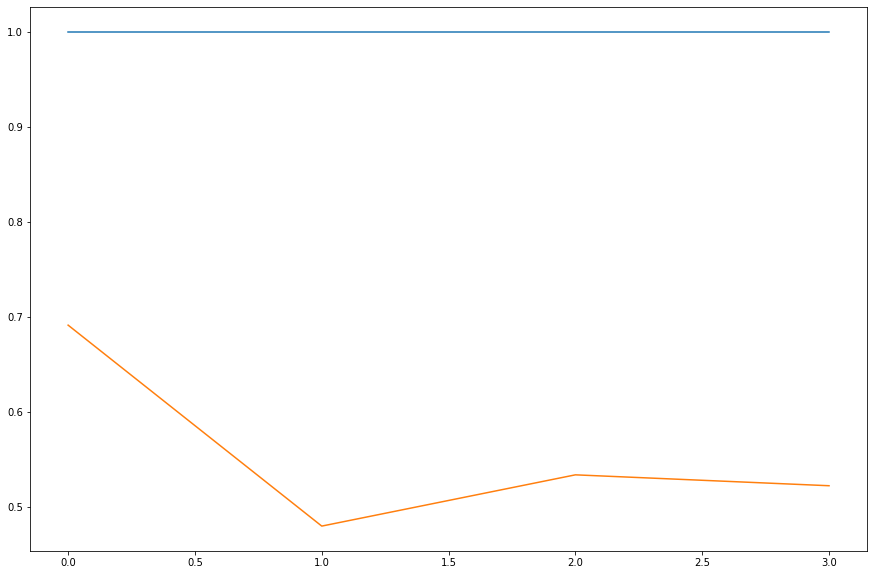

In [47]:
predictions_slice = model10.predict(build_timeseries(df.iloc[slice(40236,40347)], features, 25))
classes = np.argmax(predictions_slice, axis = 1)
confidence = np.max(predictions_slice, axis = 1)
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(classes)
plt.plot(confidence)